<h1 align='center'><b>Implementation of Least Squares Twin  Support Vector Machine Algorithm</b></h1><br/>

<h5 align='center'>According to the article of<br/>
Least squares twin support vector machines for pattern classification<br/>
  M. Arun Kumar *, M. Gopal<br/>
  Control Group, Department of Electrical Engineering<br/>
  Indian Institute of Technology Delhi, Hauz Khas, New Delhi 110016, India</h5>
<h6>See full article <a href='https://www.sciencedirect.com/science/article/abs/pii/S0957417408006854'>Here</a>.</h6><br/>


---


<h5>Abdullah Mohammadi<br/>Master student in Data Science,Ferdowsi university of Mashhad</h5>
<a href='mailto:abdhmohammady@gmail.com'>abdhmohammady@gmail.com</a><br/>
<a href='https://github.com/AbdhMohammadi'>https://github.com/abdhmohammadi</a><br/>
Other social networks: @abdhmohammadi
  
---



<h1>Introduction</h1>
In this article, we are trying to implement the Least Square Twin SVM version for the SVM algorithm, for ease of expression, we will call it LSTwinSVM from now on. LSTwinSVM was published by Arun Kumar and Gopal in an article titled Least squares twin support vector machines for pattern classification in Science Direct magazine on May 4, 2009, which develops the basic SVM algorithm using two non-parallel hyperplanes. In this article, a binary classification problem is divided into two classes like other SVM methods, but instead of finding two parallel hyperplanes, it searches for non-parallel hyperplanes.

<h1>Student-Performance dataset</h1>

In the implementation of this algorithm, we use the Student-Performance.csv dataset, which is briefly described below for the reader's familiarity:

These data are about student progress in two secondary schools in Portugal. This collection is presented in relation to students' performance in two subjects: mathematics (mat) and Portuguese language (por). Data characteristics include student grades, demographic, family, social, and school data collected using school reports and questionnaires. The target characteristic of G3 is third-year grades. See <a href='https://archive.ics.uci.edu/ml/datasets/student+performance'>here</a> for more details.

<h1>Import required libraries</h1>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from numpy.matlib import matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
A = matrix([[1,1,1],[2,2,2]])
B = matrix([[3,3,3],[1,1,1],[4,4,4],[5,2,1]])
C = A*B.T
C.shape

(2, 4)

# Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA/Student-Performance.csv')
#for c in df.columns: print('Total Missing values in \'{}\' are {}.'.format(c,df[c].isna().sum()))
#Replace mean of 'age' column for each missing value
age_mean = int(df["age"].mean())
df['age'] = df['age'].fillna(age_mean)

#Replace mean of 'freetime' column for each missing value
freetime_mean =int(df["freetime"].mean())
df['freetime'] = df['freetime'].fillna(age_mean)

guardian =['mother','father','father']
#Replace random selection of 'mother' and 'father' for each missing value of 'gradiant' column
for i in range(len(df["guardian"])):
  if pd.isnull(df["guardian"][i]):
     df.at[i,"guardian"] = np.random.choice(guardian)

#Generate new column and set 'Passed' as default value

df['G'] ='Passed'

#Update values of column 'G' asosioted by values of 'G3'.
#if each value of 'G3' is lower than 10, value of 'G' changes to 'Failure'
for i, row in df.iterrows():
     if df.at[i,'G3']<10 : df.at[i,'G'] = 'Failure'
         
#remove 'G3'
del df['G3']

#rename 'G' to 'G3'
df.rename(columns = {'G':'G3'}, inplace = True)

df['sex'] = df['sex'].map({'M': 0, 'F': 1})
df['address'] = df['address'].map({'U': 0, 'R': 1})
df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1})

#Columns 0 - 11 for predicate
predictors = df.values[:, 0:11]
#G3
targets = df.values[:,12]

features = list(df.columns[:11])

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size= 0.25)

print("Trian shape ",pred_train.shape)
print("Test shape ",pred_test.shape)
print("Target trian shape ",tar_train.shape)
print("Target test shape ",tar_test.shape)

Trian shape  (592, 11)
Test shape  (198, 11)
Target trian shape  (592,)
Target test shape  (198,)


# <h1>Algorithm of nonlinear least squares Twin SVM (LSTSVM)</h1>

Given $m_1$ datapoints in $R^n$ of class $0$ represented by matrix $A$,
and $m_2$ datapoints in $R^n$ of class $1$ represented by matrix $B$
nonlinear LSTSVM can be obtained using the following $6$ steps:

<h1>Step 1:Choose a kernel function K</h1>
We difined simple kernel selector function above.

<h3>Kernel selector function</h3>

In [ ]:
def get_kernel(name='rbf',gamma=1,degree = 2):
    def rbf(x1, x2,g=gamma):
      i = x1.shape[0]
      k = x2.shape[0]
      list_=[]
      # rows of x1
      for i1 in range(i):
        row=[]
        # rows of x2
        for l1 in range(k):
          x = x1[i1]- x2[l1]
          norm = np.linalg.norm(x)
          element = np.exp(-g*(norm**2))
          row.append(element)
        #print(row)  
        list_.append(row)
      return matrix(list_)
    #return np.exp(-cdist(x1, x2.T) ** 2)# / sigma ** 2)
    # if sigma is None: raise ValueError("'None' value is not valid for sigma")
    # else :
    # x1 and x2 are to matrices
    
    def linear(x1,x2): return x1*x2.T #np.dot(x1,x2.T)

    def poly(x1, x2, d = degree):
      # the rows of matrix 1
      i = x1.shape[0]
      k = x2.shape[0]
      list_=[]
      for i1 in range(i):
        row=[]
        #columns of x2
        for l1 in range(k):
          element = (np.double(x1[i1]*x2[l1].T)+1)**d
          #print(element)
          row.append(element)
        list_.append(row)

      return matrix(list_)
    
    kernels = {'linear': linear, 'poly': poly, 'rbf': rbf}
    
    if kernels.get(name) is None: raise KeyError( f"Kernel '{name}' is not defined, try one in the list: " f"{list(kernels.keys())}." )
    else: return kernels[name]
   

Select a kernel and penalty parameters C1 and C2.
Usually these parameters are selected based on validation.

In [ ]:
K = get_kernel(name='linear')
epsilon = 0.1 # Epsilon
C1 = 1.0
C2 = 1.0

<h1>Step 2:</h1>Define 
$C=\left[\begin{matrix}A\\B\\\end{matrix}\right]$
and  $G=[K(A,C^T) \ \  \ e]$  and $H=[K(B,C^T) \ \  \ e]$</h1><br/>

$A$ is  Matrix of class 0 datapoints and $B$ is  Matrix of class 1 datapoints.

In [ ]:
A = matrix(pred_train[tar_train=='Passed'])
B = matrix(pred_train[tar_train=='Failure'])

m1 = A.shape[0]
m2 = B.shape[0]

C = np.concatenate((A,B))

KAC=K(A,C)

e = np.ones((KAC.shape[0],1))
G = np.hstack((KAC,e))

KBC = K(B,C)

e = np.ones((KBC.shape[0],1))
H = np.hstack((KBC,e))

print("m1 =",m1)
print("m2 =",m2)
print("Shape of K(A,C) = ",KAC.shape)
print("Shape of K(B,C) = ",KBC.shape)

print("Shape of G = ",G.shape)
print("Shape of H = ",H.shape)


m1 = 393
m2 = 199
Shape of K(A,C) =  (393, 592)
Shape of K(B,C) =  (199, 592)
Shape of G =  (393, 593)
Shape of H =  (199, 593)


<h1>Step 4.1</h1>

calculate $m_1$ and $m_2$ and determine $\ \  m_1$<$\ m_2$ or not?

<h1>$\ if \ \ m_1$<$m_2$</h1>

if $m_1$<$m_2$ determine the parameters of two hypersurfaces using

$Y=\frac{1}{\varepsilon}(I-H^T(\varepsilon I+HH^T)^{-1}H)$

$
\left[\begin{matrix}u_1\\b_1\\\end{matrix}\right]=-\left(Y-YG^T(C_1I+GYG^T\right)^{-1}{GY)H}^Te
$

$
\left[\begin{matrix}u_2\\b_2\\\end{matrix}\right]={C_2{(Y-YG}^T(\frac{I}{C_2}+GYG^T)}^{-1}GY)G^Te
$

In [ ]:
if m1<m2:
  HHT= H*H.T

  ieps = epsilon*np.identity(HHT.shape[0])
  INV = np.linalg.inv(ieps + HHT)

  HTINVH = H.T*INV*H
  i = np.identity(HTINVH.shape[0])
  Y = (1/epsilon)*(i- HTINVH)

  GYGT = G*Y*G.T
  i = np.identity(GYGT.shape[0])
  ic1 = C1*i
  INV = np.linalg.inv(ic1+ GYGT)
  ZGTINVGZGT = -1*(Y - Y*G.T*INV*G*Y)*H.T
  e = np.ones((ZGTINVGZGT.shape[1],1))
  u1b1 = ZGTINVGZGT*e
  #print("u1,b1",u1b1)

  # u1 ,b1
  INV = np.linalg.inv((1/C2)*i+GYGT)
  ZHTHZG = C2*(Y - Y*G.T*INV*G*Y)*G.T
  e = np.ones((ZHTHZG.shape[1],1))
  u2b2 = ZHTHZG*e


<h1>Step 4.2: $\ if \ \ m_1\geq m_2$</h1>
if $m_1\geq m_2$  determine the parameters of two hypersurfaces using

$Z=\frac{1}{\varepsilon}(I-{G}^T(\varepsilon I+GG^T)^{-1}G)$

$
\left[\begin{matrix}u_1\\b_1\\\end{matrix}\right]=-{C_1{(Z-ZH}^T(\frac{I}{C_1}+HZH^T)}^{-1}HZ)H^Te
$

$
\left[\begin{matrix}u_2\\b_2\\\end{matrix}\right]=\left(Z-ZH^T(C_2I+HZH^T\right)^{-1}{HZ)G}^Te
$

In [ ]:
if m1>=m2:
  
  GGT= (G*G.T).astype('float64')

  ieps = (epsilon*np.identity(GGT.shape[0])).astype('float64')
  INV = np.linalg.inv(ieps + GGT)

  GTINVG = G.T*INV*G
  i = np.identity(GTINVG.shape[0])
  Z = (1/epsilon)*(i- GTINVG)
  
  print("Shape of Z =",Z.shape)

  HZHT = (H*Z*H.T).astype('float64')
  i = np.identity(HZHT.shape[0])
  ic1 = (1/C1)*i
  INV = np.linalg.inv(ic1+ HZHT)
  ZHTINVHZHT = (-C1*(Z - Z*H.T*INV*H*Z)*H.T)
  e = np.ones((ZHTINVHZHT.shape[1],1))
  u1b1 = ZHTINVHZHT*e
  print("Shape of (u1,b1) =",u1b1.shape)

  # u1 ,b1
  INV = np.linalg.inv(C2*i+HZHT)
  ZHTHZG = (Z - Z*H.T*INV*H*Z)*G.T
  e = np.ones((ZHTHZG.shape[1],1))
  u2b2 = ZHTHZG*e
  
  print("Shape of (u2,b2)=",u2b2.shape)

Shape of Z = (593, 593)
Shape of (u1,b1) = (593, 1)
Shape of (u2,b2)= (593, 1)


<h1>Step 5:</h1>

Calculate perpendicular distances  $|K(X,C)u_1+b_1|$ and $|K(X,C)u_2 + b_2|$ for a new datapoint $X \in R^n$
.

<h1>Spep 5.1:</h1>split $u_1,b_1, u_2, b_2$

In [ ]:
# Split u1 and b1
last_index = u1b1.shape[0]-1
b1 = np.double(u1b1[last_index,0])
u1 = np.delete(u1b1, last_index, 0)

# Split u2 and b2
last_index = u2b2.shape[0]-1
b2 = np.double(u2b2[last_index,0])
u2 = np.delete(u2b2, last_index, 0)

print("b1=",b1,",b2",b2,"\n")

print("u1.T=",u1.T.shape)
print("u2.T=",u2.T.shape)

b1= -0.36525134751827093 ,b2 2.8234077355780087 

u1.T= (1, 592)
u2.T= (1, 592)


<h1>Step 5.2: Predicting</h1>
calculate norm of  $|K(X,C)u_1+b_1|$ and $|K(X,C)u_2 + b_2|$ for a new datapoint $X \in R^n$ and assign the datapoint to class 0 or 1 based on which of the distance $|K(X,C)u_1+b_1|$ and $|K(X,C)u_2 + b_2|$ is minimum

In [ ]:
X_ = matrix(pred_test)
predicted = []
rows = X_.shape[0]
j=0

while j < rows:
  x = X_[j]
  d1 = abs(np.double(K(x,C)*u1)+b1)
  #print("d1 =",d1)

  d2 = abs(np.double(K(x,C)*u2)+b2)
  #print("d2=",d2)
  if d1<=d2: predicted.append(0)
  else : predicted.append(1)
  
  j+=1

predicted=[]
rows = X_.shape[0]
j=0
#K = get_kernel(name=self.kernel_name)
while j < rows:
  x = X_[j]
  d1 = abs(np.double(K(x,C)*u1)+b1)
  d2 = abs(np.double(K(x,C)*u2)+b2)
  if d1<=d2:
        predicted.append(0)
  else :
        predicted.append(1)
  j+=1

print(predicted)

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


# <h1>Full code</h1>

Based on the steps explained above, we have packaged the algorithm in a class as follows:

In [ ]:
class LSTwinSVM:
  # init method or constructor
  def __init__(self):
    
    self.b1 = np.double(0)
    self.b2 = np.double(0)
    self.u1 = matrix(0)
    self.u2 = matrix(0)
    self.C  = matrix(0)
    self.predicted = []
    self.confusion_matrix = matrix(0)
    self._C1= 0.0
    self._C2 = 0.0
    self._epsilon = 0.1
    
    self.confusion_matrix = matrix(0)
    self.K = None
    
  def fit(self,train_set,target_set,C1=1.0,C2=1.0,gamma = 1.0,epsilon=0.1,kernel='rbf',degree = 2):
    self._epsilon = epsilon # Epsilon
    self._C1 = C1
    self._C2 = C2

    self.K = get_kernel(name = kernel,gamma=gamma,degree = degree)
    
    self.classes = (pd.Series(target_set)).unique()

    if len(self.classes)>2:
      raise Exception("Multiclass not supported")

    A = matrix(train_set[target_set==self.classes[0]])
    
    B = matrix(train_set[target_set==self.classes[1]])

    self.C = np.concatenate((A,B))
   
    m1 = A.shape[0]
    m2 = B.shape[0]
    
    KAC= self.K(A,self.C)
    e = np.ones((KAC.shape[0],1))
    G = np.hstack((KAC,e))
    KBC = self.K(B,self.C)
    e = np.ones((KBC.shape[0],1))
    H = np.hstack((KBC,e))
    print("m1",m1,", m2",m2)
    if m1>= m2:
      GGT= (G*G.T).astype('float64')
      ieps = (epsilon*np.identity(GGT.shape[0])).astype('float64')
      INV = np.linalg.inv(ieps + GGT)

      GTINVG = G.T*INV*G
      i = np.identity(GTINVG.shape[0])
      Z = (1/epsilon)*(i- GTINVG)

      HZHT = (H*Z*H.T).astype('float64')
      i = np.identity(HZHT.shape[0])
      ic1 = (1/C1)*i
      INV = np.linalg.inv(ic1+ HZHT)
      ZHTINVHZHT = (-C1*(Z - Z*H.T*INV*H*Z)*H.T)
      e = np.ones((ZHTINVHZHT.shape[1],1))
      u1b1 = ZHTINVHZHT*e
      #print("u1,b1",u1b1)

      # u2 ,b2
      INV = np.linalg.inv(C2*i+HZHT)
      ZHTHZG = (Z - Z*H.T*INV*H*Z)*G.T
      e = np.ones((ZHTHZG.shape[1],1))
      u2b2 = ZHTHZG*e
      #print("u2,b2",u2b2)
    else:
      HHT= H*H.T
      ieps = epsilon*np.identity(HHT.shape[0])
      INV = np.linalg.inv(ieps + HHT)
    
      HTINVH = H.T*INV*H
      i = np.identity(HTINVH.shape[0])
      Y = (1/epsilon)*(i- HTINVH)

      GYGT = G*Y*G.T
      i = np.identity(GYGT.shape[0])
      ic1 = C1*i
      INV = np.linalg.inv(ic1+ GYGT)
      ZGTINVGZGT = -1*(Y - Y*G.T*INV*G*Y)*H.T
      e = np.ones((ZGTINVGZGT.shape[1],1))
      u1b1 = ZGTINVGZGT*e
      #print("u1,b1",u1b1)
      # u2 ,b2
      INV = np.linalg.inv((1/C2)*i+GYGT)
      ZHTHZG = C2*(Y - Y*G.T*INV*G*Y)*G.T
      e = np.ones((ZHTHZG.shape[1],1))
      u2b2 = ZHTHZG*e
    
    #print("u2,b2",u2b2)
    # Split u1 and b1
    last_index = u1b1.shape[0]-1
    self.b1 = np.double(u1b1[last_index,0])
    self.u1 = np.delete(u1b1, last_index, 0)

    # Split u2 and b2
    last_index = u2b2.shape[0]-1
    self.b2 = np.double(u2b2[last_index,0])
    self.u2 = np.delete(u2b2, last_index, 0)

  def predict(self,x_test):
    self.predicted=[]
    X_ = matrix(x_test)
    rows = X_.shape[0]
    j=0
    #K = get_kernel(name=self.kernel_name)
    while j < rows:
      x = X_[j]
      d1 = abs(np.double(self.K(x,self.C)*self.u1)+self.b1)
      d2 = abs(np.double(self.K(x,self.C)*self.u2)+self.b2)
      
      if d1<=d2:
        self.predicted.append(0)
      else :
        self.predicted.append(1)
      j+=1
    return self.predicted

  def make_confusion_matrix(self,y_true):
    def make_binary(self,data):
        i = 0 
        cont = len(data)
        y_=[]
        while i< cont:
          if data[i]== self.classes[0]:
              y_.append(0)
          else: y_.append(1)
          i+=1
        return y_

    y__ = make_binary(self,y_true)
    #print("binary     :",y__)
    cm = metrics.confusion_matrix(y__, self.predicted)
    #print("Confiusion Matrix:",cm)
    #Accuracy formula = (TN+TP)/All
    self.accuracy = (cm[0,0]+ cm[1,1])/(cm[0,0]+ cm[0,1]+ cm[1,0]+ cm[1,1])
    #Error rate
    self.error = 1- self.accuracy 
    #Recall(Sensitivity)
    self.sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    #Specificity
    self.specificity = cm[0,0]/(cm[0,0]+cm[1,0])
    self.confusion_matrix = cm
    
    return cm
  def print_info(self):

      print("classes:",self.classes)
      #Accuracy = TP + TN / (TP + TN + FP + FN)
      print("Score:",self.accuracy)
      print("Error:",self.error)
      #Recall = TP / (TP +FN)
      print("Recall(Sensitivity):",self.sensitivity)
      print("Specificity:",self.specificity)
      # F1 = 2*(Recall * Precision) / (Recall + Precision)
      # Precision = TP / (TP + FP)

      print("Confusion matrix")
      cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = self.confusion_matrix, display_labels = [False, True])
      cm_display.plot()
      plt.show()

# **<h1>Our 'LSTwinSVM' Classifier usage<h1>**
In this section, we compare the results of three common kernels
<ul><li><b>Linear kernel</b></li></ul>

m1 386 m2 206
classes: ['Passed' 'Failure']
Score: 0.7575757575757576
Error: 0.24242424242424243
Recall(Sensitivity): 0.9583333333333334
Specificity: 0.7666666666666667
Confusion matrix


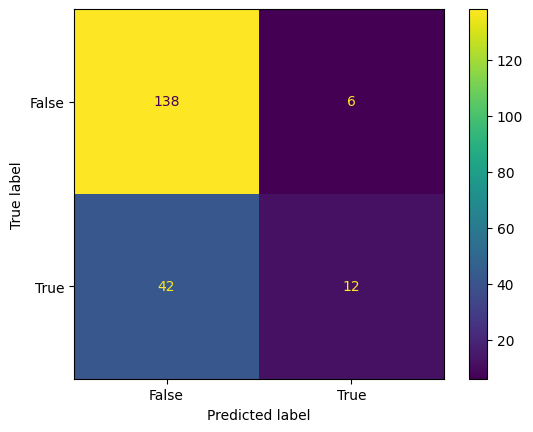

In [ ]:
clf = LSTwinSVM()

clf.fit(pred_train,tar_train,kernel='linear')

clf.predict(pred_test)
clf.make_confusion_matrix(tar_test)

clf.print_info()

<ul><li><b>RBF kernel</b></li></ul>

m1 386 m2 206
classes: ['Passed' 'Failure']
Score: 0.898989898989899
Error: 0.101010101010101
Recall(Sensitivity): 1.0
Specificity: 0.8780487804878049
Confusion matrix


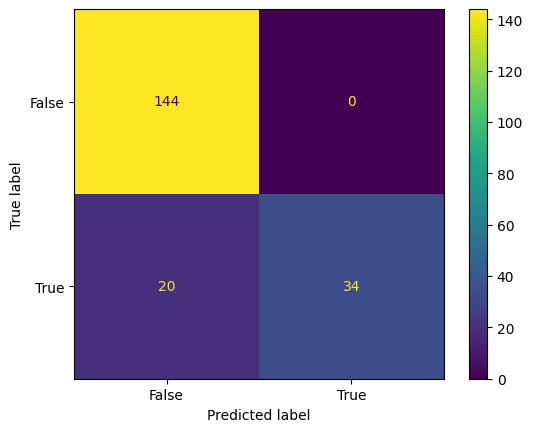

In [ ]:
clf.fit(pred_train,tar_train,kernel='rbf')

clf.predict(pred_test)
clf.make_confusion_matrix(tar_test)

clf.print_info()

<ul><li><b>Polynomial kernel</b></li></ul>

m1 386 m2 206
classes: ['Passed' 'Failure']
Score: 0.7121212121212122
Error: 0.28787878787878785
Recall(Sensitivity): 0.9791666666666666
Specificity: 0.7230769230769231
Confusion matrix


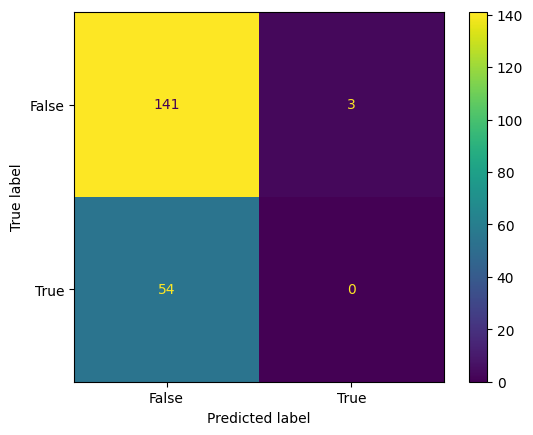

In [ ]:
clf.fit(pred_train,tar_train,kernel='poly',epsilon=0.5)

clf.predict(pred_test)
clf.make_confusion_matrix(tar_test)

clf.print_info()

m1 386 m2 206
classes: ['Passed' 'Failure']
Score: 0.7676767676767676
Error: 0.23232323232323238
Recall(Sensitivity): 0.9027777777777778
Specificity: 0.8024691358024691
Confusion matrix


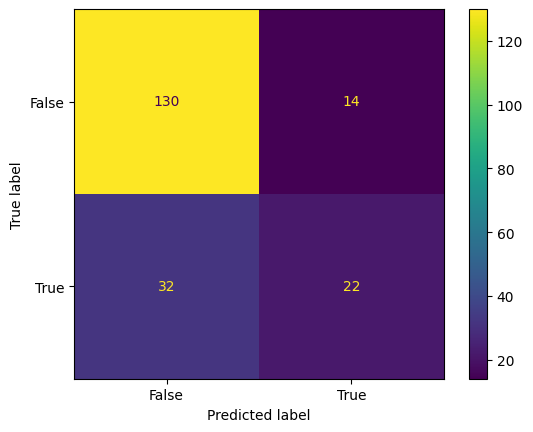

In [ ]:
clf.fit(pred_train,tar_train,kernel='rbf',gamma=0.001)

clf.predict(pred_test)
clf.make_confusion_matrix(tar_test)

clf.print_info()

<b>Final remarks:</b> In this discussion, we tried to meet the minimum implementation requirements of this algorithm, for those interested, it is possible to improve its performance by testing different parameters on various datasets, the author hopes to receive any feedback via email or Receive on other platforms including GitHub and social networks.

---
<b>Abdullah Mohammadi<br/>Master student in Data Science,Ferdowsi university of Mashhad</b><br/>
<a href='mailto:abdhmohammady@gmail.com'>abdhmohammady@gmail.com</a><br/>
<a href='https://github.com/AbdhMohammadi'>https://github.com/abdhmohammadi</a><br/>
Other social networks: @abdhmohammadi